In [1]:
from sklearn.cluster import KMeans

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import esp
%matplotlib inline

### Find regions of color space spanned by training space as a function of wavelength

In [96]:
# Load in training set with a k-means group taken out
color_gap_train_set = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')

In [114]:
# Load training set with full colors
full_train_set = pd.read_csv('../data/train_cat_full.dat')

In [115]:
z_vals = np.arange(0, 3.51, 0.05)

In [116]:
# Bin by redshift
z_bins = np.digitize(color_gap_train_set['redshift'], z_vals)

In [117]:
z_bins = z_bins-1

In [118]:
color_gap_train_set['z_bins'] = z_bins

In [119]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']

In [131]:
colors = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

In [120]:
for i in range(5):
    color_gap_train_set['%s-%s' % (filters[i], filters[i+1])] = \
        color_gap_train_set[filters[i]]-color_gap_train_set[filters[i+1]]

In [121]:
cluster_centers = {}

In [122]:
color_gap_train_set.head()

,redshift,u,g,r,i,z,y,z_bins,u-g,g-r,r-i,i-z,z-y
0,0.708277,27.5278,27.4826,27.0514,26.4112,26.3398,26.3135,14,0.0452,0.4312,0.6402,0.0714,0.0263
1,3.297912,31.7478,26.6329,25.4428,25.3954,25.7079,25.7969,65,5.1149,1.1901,0.0474,-0.3125,-0.0890
2,2.175147,26.4805,26.1697,26.2675,26.3462,26.2657,26.2155,43,0.3108,-0.0978,-0.0787,0.0805,0.0502
3,2.100762,30.7369,28.4791,27.5407,27.2548,26.6204,26.2846,42,2.2578,0.9384,0.2859,0.6344,0.3358
4,2.097417,26.6531,26.4531,26.5904,26.6739,26.6440,26.6244,41,0.2000,-0.1373,-0.0835,0.0299,0.0196


In [123]:
for bin_idx in range(70):
    if bin_idx % 5 == 0:
        print(bin_idx)
    km = KMeans(n_clusters=50, random_state=18).fit(
        color_gap_train_set.query('z_bins == %i' % bin_idx)[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']])
    cluster_centers[str(bin_idx)] = km.cluster_centers_

0
5
10
15
20
25
30
35
40
45
50
55
60
65


### Fit ESP GP process for each redshift bin of original templates

In [35]:
template_dir = '../data/templates/brown/'

In [36]:
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(template_dir)

for pca_sed in pca_obj.spec_list_orig:
    pca_sed.wavelen /= 10.
#pca_obj.PCA(comps=8, minWavelen=49., maxWavelen=1200.)

File On 100 out of 129
Done loading spectra from file


In [39]:
bandpass_dir = '../../ESP/data/lsst_bandpasses/'
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = esp.lsst_utils.BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

In [40]:
pca_obj.spec_list_orig = pca_obj.spec_list_orig[:-1]

In [41]:
print(len(pca_obj.spec_list_orig))

129


In [51]:
from copy import deepcopy
colors_dict = {}
mags = []
spec_val = []
redshift = []
spec_dict = {}
for z_bin_idx in range(70):
    z_shift = z_vals[z_bin_idx]
    test_sed_list = []
    test_colors_list = []
    for sed_obj in pca_obj.spec_list_orig:
        test_sed = deepcopy(sed_obj)
        test_sed.redshiftSED(z_shift)
        test_sed_list.append(test_sed)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags.append(sed_mags)
        colors = sed_mags[:-1] - sed_mags[1:]
        test_colors_list.append(colors)

    spec_dict[str(z_bin_idx)] = test_sed_list
    colors_dict[str(z_bin_idx)] = test_colors_list

In [124]:
final_z = np.zeros(50*50)
final_colors = np.zeros((50*50, 5))
for z_bin_idx in range(50):
    if z_bin_idx % 5 == 0:
        print(z_bin_idx)
    z_shift = z_vals[z_bin_idx]
    pca_obj.spec_list_orig = spec_dict[str(z_bin_idx)]
    pca_obj.PCA(comps=10, minWavelen=199., maxWavelen=1500.*(1+z_shift))
    #print(pca_obj.wavelengths, pca_obj.spec_list_orig[0].wavelen)
    gp_obj = esp.gaussianProcessEstimate(pca_obj, bandpass_dict, cluster_centers[str(z_bin_idx)])#colors_dict[str(z_bin_idx)])
    gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=5)
    gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bandpass_dict)
    gp_colors = gp_spec.calc_colors(bandpass_dict, 10)
    new_spec = gp_spec.reconstruct_spectra(10)

    new_colors = []
    for spec_flambda in new_spec:
        test_sed = esp.lsst_utils.Sed()
        test_sed.setSED(wavelen=pca_obj.wavelengths, flambda=spec_flambda)
        test_sed.redshiftSED(-1.0*z_shift)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        new_colors.append(sed_mags[:-1] - sed_mags[1:])
    final_z[z_bin_idx*50:(z_bin_idx+1)*50] = z_shift
    final_colors[z_bin_idx*50:(z_bin_idx+1)*50] = new_colors

0
5
10
15
20
25
30
35
40
45


In [125]:
cluster_centers_full_color = np.zeros((50*70, 5))
cl_z = np.zeros((50*70))
for cl_idx in range(70):
    cluster_centers_full_color[cl_idx*50:(cl_idx + 1)*50] = cluster_centers[str(cl_idx)]
    cl_z[cl_idx*50:(cl_idx + 1)*50] = z_vals[cl_idx]

In [111]:
cluster_centers_full = np.zeros((50*70, 5))
cl_z = np.zeros((50*70))
for cl_idx in range(70):
    cluster_centers_full[cl_idx*50:(cl_idx + 1)*50] = cluster_centers[str(cl_idx)]
    cl_z[cl_idx*50:(cl_idx + 1)*50] = z_vals[cl_idx]

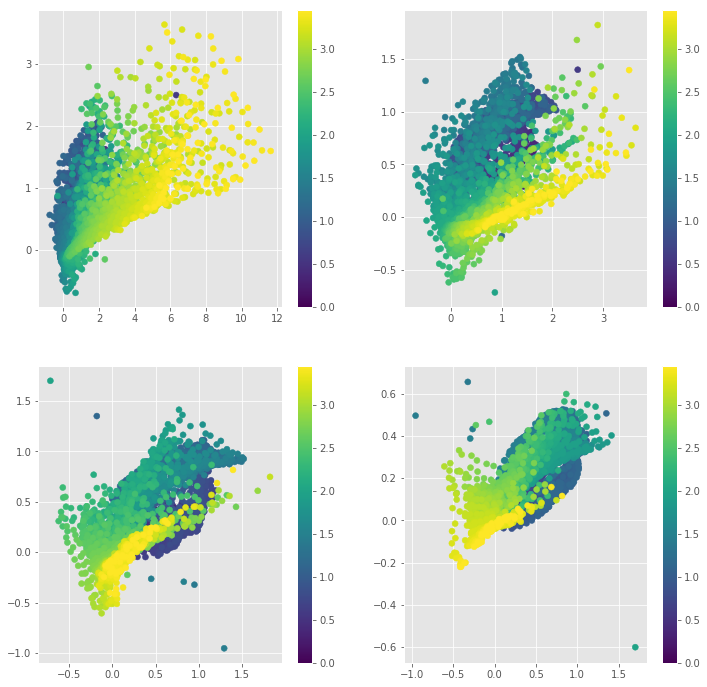

In [126]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_full_color[:,i], cluster_centers_full_color[:,i+1], c=cl_z)
    plt.colorbar()

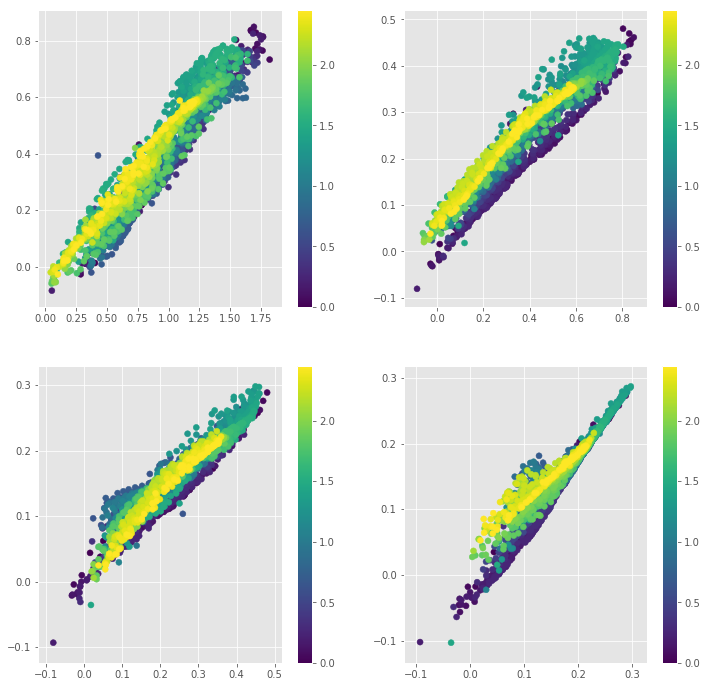

In [127]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[:,i], final_colors_full[:,i+1], c=final_z)
    plt.colorbar()

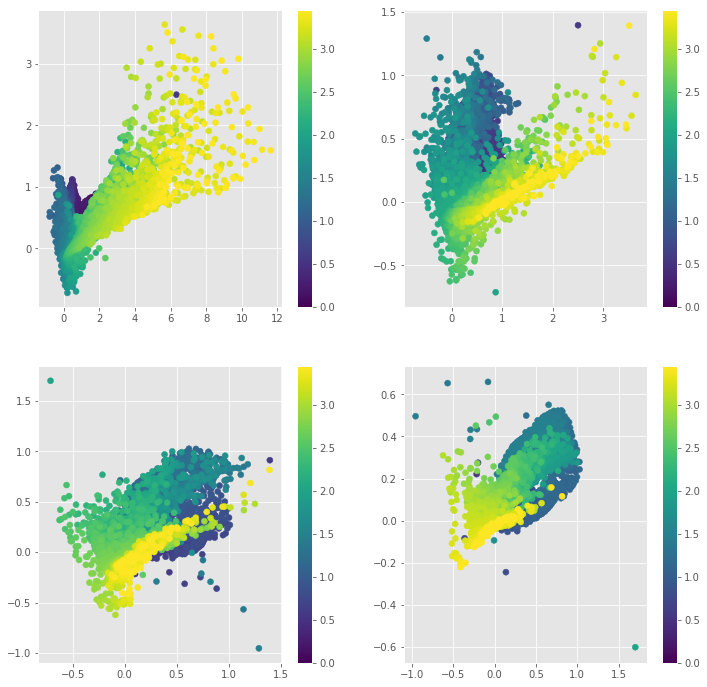

In [112]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(cluster_centers_full[:,i], cluster_centers_full[:,i+1], c=cl_z)
    plt.colorbar()

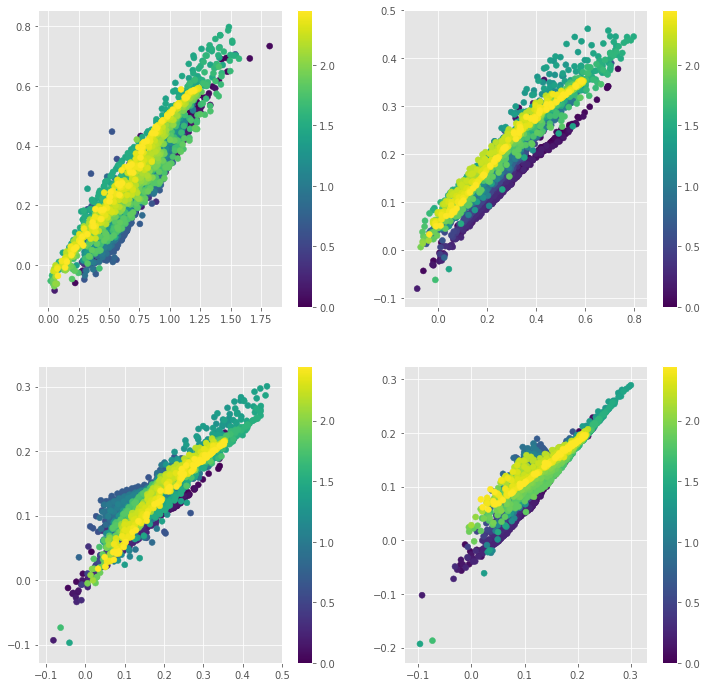

In [113]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors[:,i], final_colors[:,i+1], c=final_z)
    plt.colorbar()

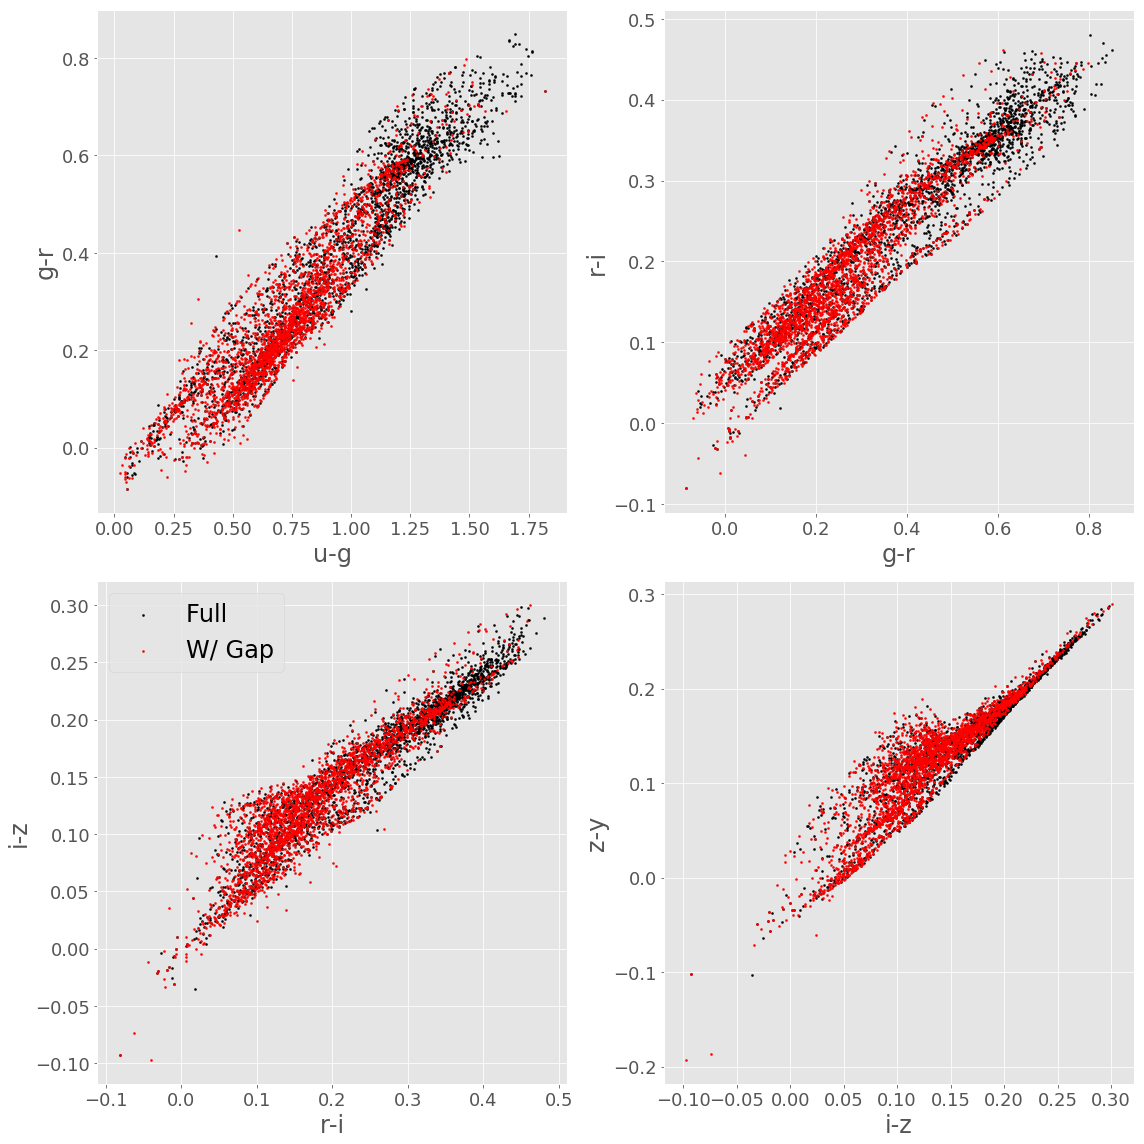

In [139]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[:,i], final_colors_full[:,i+1], c='k', label='Full', s=4, alpha=1.)
    plt.scatter(final_colors[:,i], final_colors[:,i+1], c='r', label='W/ Gap', s=4, alpha=1.)
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    if i == 2:
        plt.legend(fontsize=24)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.tight_layout()

In [141]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(final_colors)

In [142]:
distances, indices = nbrs.kneighbors(final_colors_full)

In [147]:
len(np.where(distances > 0.05)[0])

77

In [148]:
keep = np.where(distances > 0.05)[0]

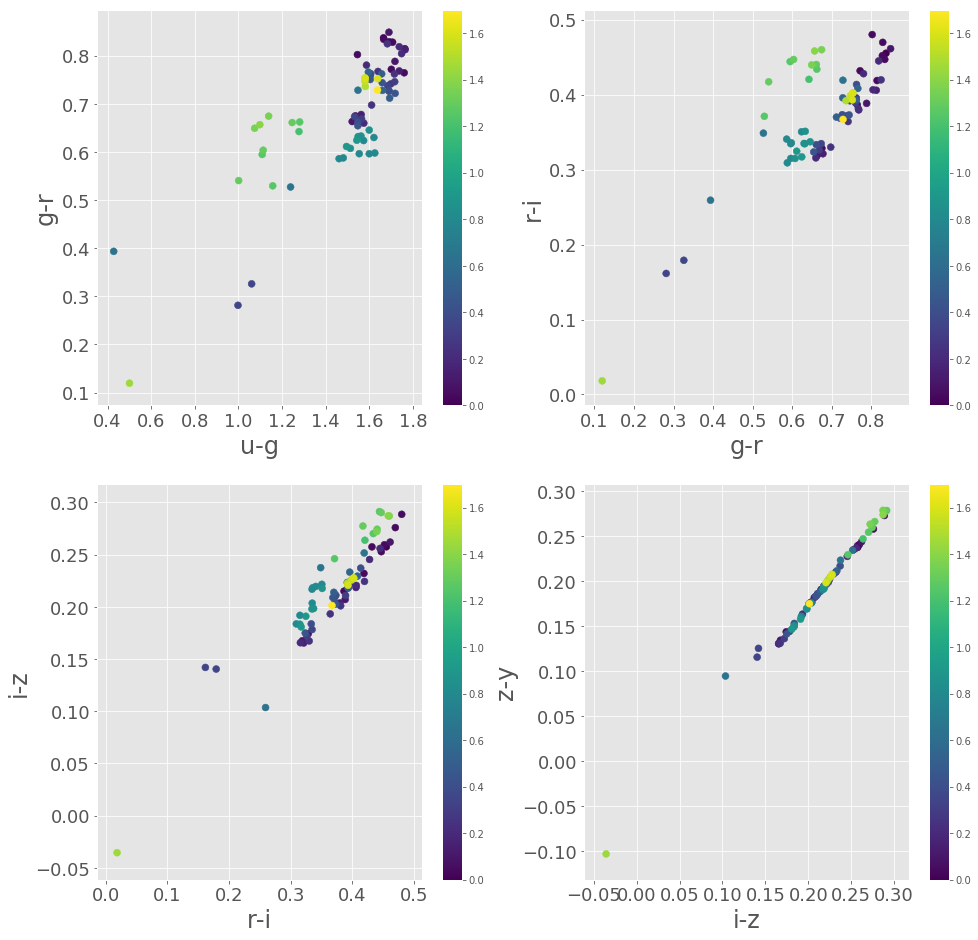

In [158]:
fig = plt.figure(figsize=(16,16))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(final_colors_full[keep,i], final_colors_full[keep,i+1], c=final_z[keep], s=48)
    plt.colorbar()
    plt.xlabel(colors[i], size=24)
    plt.ylabel(colors[i+1], size=24)
    plt.xticks(size=18)
    plt.yticks(size=18)